### Download 60 days of half-hour period stock data

In [1]:
import yfinance as yf
import pandas as pd

# List of stock tickers
tickers = ["GOOG", "AAPL", "MSFT", "TSLA", "NVDA"]  # Add as many as you like

# Parameters
period = "60d"
interval = "30m"
save_folder = "./"  # Folder to save CSVs

for ticker in tickers:
	print(f"Downloading {ticker}...")
	
	# Download data
	df = yf.download(tickers=ticker, period=period, interval=interval, auto_adjust=True)
	
	# Flatten columns if multi-indexed
	if isinstance(df.columns, pd.MultiIndex):
		df.columns = df.columns.get_level_values(0)
	
	# Convert index (Datetime) from UTC to US/Eastern
	df.index = df.index.tz_convert('US/Eastern')
	
	# Save to CSV
	filename = f"{save_folder}{ticker}_{period}_{interval}.csv"
	df.to_csv(filename)
	print(f"{ticker} data saved to {filename}\n")

[*********************100%***********************]  1 of 1 completed


GOOG data saved to ./GOOG_60d_30m.csv



[*********************100%***********************]  1 of 1 completed


AAPL data saved to ./AAPL_60d_30m.csv



[*********************100%***********************]  1 of 1 completed


MSFT data saved to ./MSFT_60d_30m.csv



[*********************100%***********************]  1 of 1 completed


TSLA data saved to ./TSLA_60d_30m.csv



[*********************100%***********************]  1 of 1 completed

NVDA data saved to ./NVDA_60d_30m.csv




Processing AAPL_60d_30m.csv...
Historically, the best day/time to BUY is Monday at 17:00:00 (avg close=209.20)
Historically, the best day/time to SELL is Thursday at 15:00:00 (avg close=211.71)


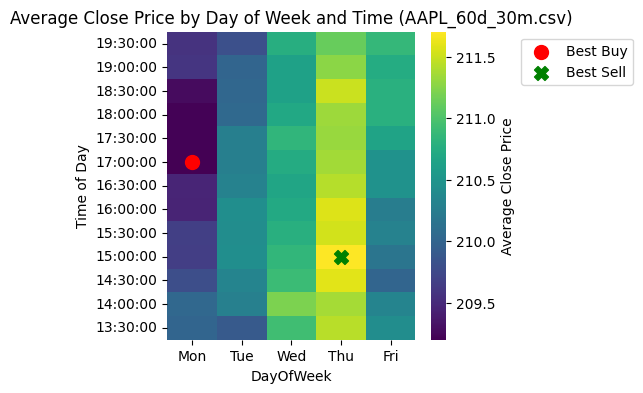


Processing GOOG_60d_30m.csv...
Historically, the best day/time to BUY is Monday at 16:00:00 (avg close=183.98)
Historically, the best day/time to SELL is Friday at 18:00:00 (avg close=186.37)


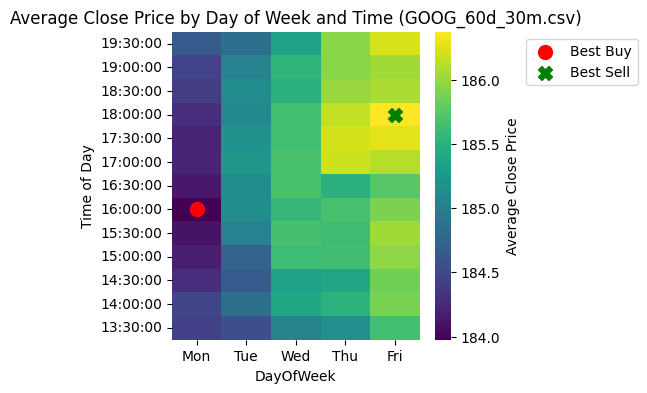


Processing MSFT_60d_30m.csv...
Historically, the best day/time to BUY is Wednesday at 18:30:00 (avg close=497.84)
Historically, the best day/time to SELL is Thursday at 17:00:00 (avg close=501.04)


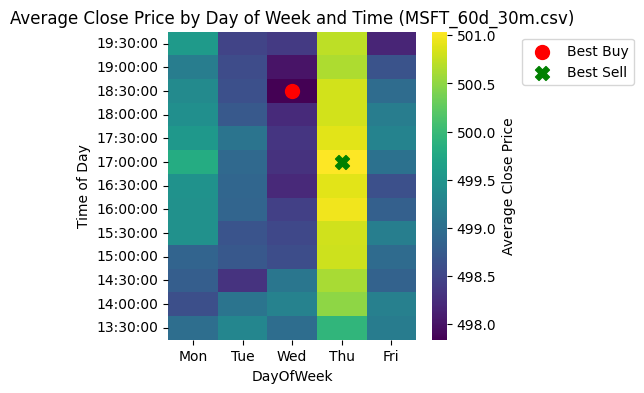


Processing TSLA_60d_30m.csv...
Historically, the best day/time to BUY is Thursday at 19:00:00 (avg close=318.87)
Historically, the best day/time to SELL is Monday at 19:30:00 (avg close=324.61)


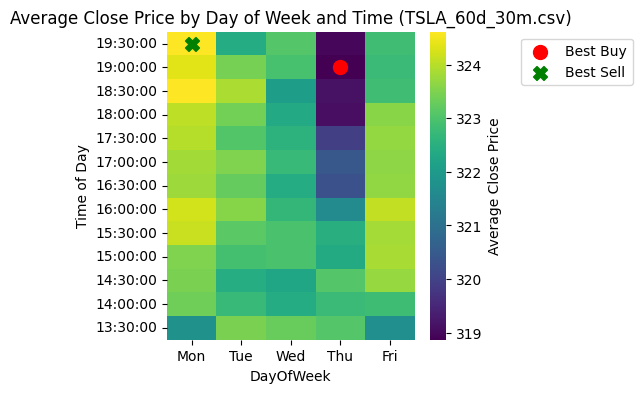


Processing NVDA_60d_30m.csv...
Historically, the best day/time to BUY is Monday at 13:30:00 (avg close=161.35)
Historically, the best day/time to SELL is Thursday at 14:00:00 (avg close=164.52)


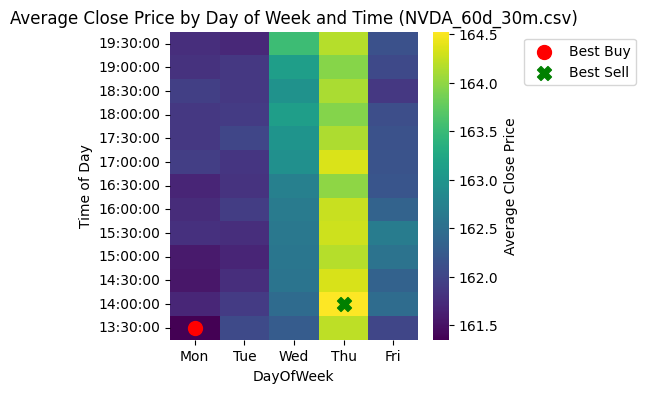

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- List your CSV files ----------------
csv_files = [
    "AAPL_60d_30m.csv",
    "GOOG_60d_30m.csv",
    "MSFT_60d_30m.csv",
    "TSLA_60d_30m.csv",
	"NVDA_60d_30m.csv"
]

days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

for file in csv_files:
	print(f"\nProcessing {file}...")
	
	# Load CSV
	df = pd.read_csv(file)  # Must contain 'Datetime' and 'Close'
	
	# Sort and extract day and time
	df["Datetime"] = pd.to_datetime(df["Datetime"], utc=True)
	df = df.sort_values("Datetime")
	df["DayOfWeek"] = df["Datetime"].dt.dayofweek  # Monday=0
	df["Time"] = df["Datetime"].dt.floor("30min").dt.time
	
	# Compute average Close price per day+time
	avg_price = df.groupby(["DayOfWeek", "Time"])["Close"].mean().reset_index()
	
	# ---------------- Best Buy ----------------
	best_buy = avg_price.loc[avg_price["Close"].idxmin()]
	best_buy_day = days[best_buy["DayOfWeek"]]
	best_buy_time = best_buy["Time"]
	
	# ---------------- Best Sell ----------------
	best_sell = avg_price.loc[avg_price["Close"].idxmax()]
	best_sell_day = days[best_sell["DayOfWeek"]]
	best_sell_time = best_sell["Time"]
	
	print(f"Historically, the best day/time to BUY is {best_buy_day} at {best_buy_time} "
		f"(avg close={best_buy['Close']:.2f})")
	print(f"Historically, the best day/time to SELL is {best_sell_day} at {best_sell_time} "
		f"(avg close={best_sell['Close']:.2f})")
    
	# ---------------- Heatmap ----------------
	avg_price["TimeStr"] = avg_price["Time"].astype(str)
	heatmap_data = avg_price.pivot(index="TimeStr", columns="DayOfWeek", values="Close")
    
	plt.figure(figsize=(4, 4))
	ax = sns.heatmap(heatmap_data, cmap="viridis", cbar_kws={'label': 'Average Close Price'})

	# Invert y-axis
	ax.invert_yaxis()

	# Highlight best buy
	buy_x = best_buy["DayOfWeek"] + 0.5
	buy_y = list(heatmap_data.index).index(str(best_buy_time)) + 0.5
	ax.scatter(buy_x, buy_y, color="red", s=100, marker="o", label="Best Buy")

	# Highlight best sell
	sell_x = best_sell["DayOfWeek"] + 0.5
	sell_y = list(heatmap_data.index).index(str(best_sell_time)) + 0.5
	ax.scatter(sell_x, sell_y, color="green", s=100, marker="X", label="Best Sell")

	# Labels, title, and legend outside
	ax.set_xticks([i + 0.5 for i in range(5)])  # center of each cell
	ax.set_xticklabels(["Mon","Tue","Wed","Thu","Fri"])
	ax.set_ylabel("Time of Day")
	ax.set_title(f"Average Close Price by Day of Week and Time ({file})")

	# Move legend further right
	ax.legend(loc='upper left', bbox_to_anchor=(1.4, 1))

	plt.show()